In [1]:
import numpy as np
import matplotlib.pyplot as pp
import pandas as pd
import heapq
import pycbc.waveform
from pycbc.types import FrequencySeries
%matplotlib inline
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
import pycbc.filter

pd.set_option('display.float_format', lambda x: '%.3e' % x)

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter, NullFormatter
from matplotlib.ticker import MaxNLocator
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.size'] = 25
mpl.rcParams['legend.handlelength'] = 3.0
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['xtick.minor.width'] = 1.0
mpl.rcParams['xtick.major.size'] = 5.0
mpl.rcParams['xtick.minor.size'] = 3.0
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['ytick.minor.width'] = 1.0
mpl.rcParams['ytick.major.size'] = 5.0
mpl.rcParams['ytick.minor.size'] = 3.0
mpl.rcParams['ytick.right'] = True

plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = '\\usepackage{sfmath}'

In [3]:
def unlensed_waveform(**args):
    
    theta_s = args['theta_s']
    phi_s = args['phi_s']
    theta_l = args['theta_l']
    phi_l = args['phi_l']
    mcz = args['mcz']
    dist = args['dist']
    eta = args['eta']
    tc = args['tc']
    phi_c = args['phi_c']
    flow = args['f_lower']
    
    df = args['delta_f']
    
    def limit(mcz, eta):
        low_limit = 20
        f_cut = 1 / (np.power(6, 3/2) * np.pi * ((mcz) / (np.power(eta, 3/5))))
        return low_limit, f_cut
   
    f = np.arange(flow, limit(mcz, eta)[1], df)

    """
    This file is just functionized form of L_unlensed(which was "object-oriented"). This was mainly created
    for the optimization of overlap function.
    """
    def mass_conv(mcz, eta):
        """Converts chirp mass to total mass. M = mcz/eta^(3/5)
        """

        M_val = mcz/np.power(eta, 3/5)
        return M_val

    def l_dot_n(theta_s, theta_l, phi_s, phi_l):
        """TODO
        """

        cos_term = np.cos(theta_s) * np.cos(theta_l)
        sin_term = np.sin(theta_s) * np.sin(theta_l) * np.cos(phi_s - phi_l)

        inner_prod = cos_term + sin_term
        return inner_prod

    def amp(mcz, dist):
        """TODO
        """

        amplitude = np.sqrt(5 / 96) * np.power(np.pi, -2 / 3) * np.power(mcz, 5 / 6) / (dist)
        return amplitude

    def psi(f, tc, phi_c, mcz, eta):
        """eqn 3.13 in Cutler-Flanaghan 1994
        """

        front_terms = 2 * np.pi * f * tc - phi_c - np.pi / 4
        main_coeffs = 0.75 * np.power(8 * np.pi * mcz * f, -5 / 3)
        main_terms = (1 + 20 / 9 * (743 / 336 + 11 / 4 * eta) * np.power(np.pi * mass_conv(mcz, eta) * f, 2 / 3)
                        - (16 * np.pi) * np.power(np.pi * mass_conv(mcz, eta) * f, 1))

        psi_val = front_terms + main_coeffs * (main_terms)
        return psi_val

    def psi_s(theta_s, theta_l, phi_s, phi_l):

        numerator = np.cos(theta_l)-np.cos(theta_s)*(l_dot_n(theta_s, theta_l, phi_s, phi_l))
        denominator = np.sin(theta_s)*np.sin(theta_l)*np.sin(phi_l-phi_s)

        psi_s_val = np.arctan2(numerator, denominator)
        return psi_s_val


    def fIp(theta_s, phi_s):
        """TODO
        """

        term_1 = (1 / 2 * (1 + np.power(np.cos(theta_s), 2)) * np.cos(2*phi_s)* np.cos(2*psi_s(theta_s, theta_l, phi_s, phi_l)))
        term_2 = (np.cos(theta_s) * np.sin(2*phi_s)* np.sin(2*psi_s(theta_s, theta_l, phi_s, phi_l)))

        fIp_val = term_1 - term_2
        return fIp_val

    def fIc(theta_s, phi_s):
        """TODO
        """

        term_1 = (1 / 2 * (1 + np.power(np.cos(theta_s), 2)) * np.cos(2*phi_s)
                    * np.sin(2*psi_s(theta_s, theta_l, phi_s, phi_l)))
        term_2 = (np.cos(theta_s) * np.sin(2*phi_s)
                    * np.cos(2*psi_s(theta_s, theta_l, phi_s, phi_l)))

        fIc_val = term_1 + term_2
        return fIc_val

    def lambdaI():
        """TODO
        """

        term_1 = np.power(2 * l_dot_n(theta_s, theta_l, phi_s, phi_l) * fIc(theta_s, phi_s), 2)
        term_2 = np.power((1 + np.power(l_dot_n(theta_s, theta_l, phi_s, phi_l), 2)) * fIp(theta_s, phi_s), 2)

        lambdaI_val = np.sqrt(term_1 + term_2)
        return lambdaI_val

    def phi_pI():
        """TODO
        """

        numerator = (2 * l_dot_n(theta_s, theta_l, phi_s, phi_l) * fIc(theta_s, phi_s))
        denominator = ((1 + np.power(l_dot_n(theta_s, theta_l, phi_s, phi_l), 2)) * fIp(theta_s, phi_s))

        phi_pI_val = np.arctan2(numerator, denominator)
        return phi_pI_val

    term_1 = lambdaI()
    term_2 = (np.exp(-1j * phi_pI()))
    term_3 = amp(mcz, dist) * np.power(f, -7 / 6)
    term_4 = np.exp(1j * psi(f, tc, phi_c, mcz, eta))

    signal_I = term_1 * term_2 * term_3 * term_4
    
    signal_I = FrequencySeries(signal_I, delta_f = df)
    return signal_I, f

In [4]:
pycbc.waveform.add_custom_waveform('unlensed', unlensed_waveform, 'frequency', force=True)

In [5]:
solar_mass = 4.92624076 * 10**-6 #[solar_mass] = sec
giga_parsec = 1.02927125 * 10**17 #[giga_parsec] = sec

hf, f = pycbc.waveform.get_fd_waveform(approximant="unlensed",
                                        theta_s = 0, phi_s = 0, theta_l = 0, phi_l = 0, 
                                        mcz = 18.79 * solar_mass, dist = 1.58 * giga_parsec, eta = 0.25,
                                        tc = 0, phi_c = 0,
                                        delta_f=1/4, f_lower = 20)

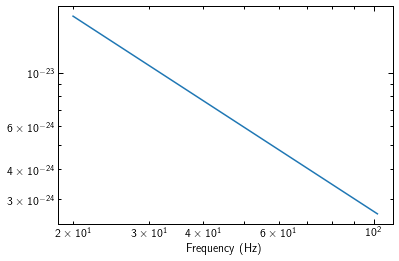

In [6]:
pp.figure(1)
pp.loglog(f, np.abs(hf))
#pp.loglog(f, f ** (-7/3))
pp.xlabel('Frequency (Hz)')
#pp.xscale('log')
#pp.xlim(20, 100)
pp.show()

### Trying SIS lens in GO regime

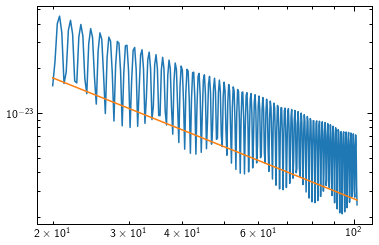

In [7]:
def amplification_factor(y, ML):
    mu_plus = 1 + 1 / y
    mu_minus = -1 + 1 / y
    td = 8 * ML * y
    amp_factor = np.sqrt(np.abs(mu_plus)) - 1j * np.sqrt(np.abs(mu_minus)) * np.exp(2 * np.pi * 1j * f * td)
    return amp_factor

hf_lensed = amplification_factor(0.5, 3.98106811e+04 * solar_mass) * hf
pp.loglog(f, np.abs(hf_lensed))
pp.loglog(f, np.abs(hf))

### Trying differest PSDs

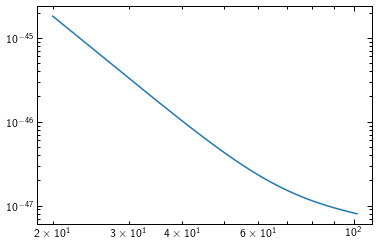

In [8]:
def Sn(f):
        """From table 1 of arXiv:0903.0338. Changed from iLIGO to aLIGO.
        """
        fs = 20
        if f < fs:
            Sn_val = np.inf
        else:
            S0 = 1E-49
            f0 = 215
            Sn_temp = np.power(f/f0, -4.14) - 5 * np.power(f/f0, -2) + 111 * ((1 - np.power(f/f0, 2) + 0.5 * np.power(f/f0, 4)) / (1 + 0.5 * np.power(f/f0, 2)))
            Sn_val = Sn_temp * S0

        return Sn_val
    
psd_analytical = np.zeros_like(f)
for i in range(len(f)):
    psd_analytical[i] = Sn(f[i])
psd_analytical = FrequencySeries(psd_analytical, delta_f = 1/4)
pp.loglog(f, psd_analytical)

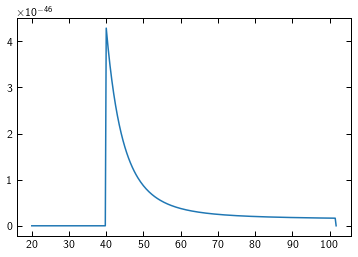

In [9]:
# Generate the aLIGO ZDHP PSD
delta_f = 1/4
flen = len(f)
f_low = 20
psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
pp.plot(f, psd)

In [10]:
m, i = match(hf, hf_lensed, psd=psd_analytical, low_frequency_cutoff=20)
m, 1 - m

(0.8660463608208335, 0.13395363917916647)

### Trying two effective images out of four images in SIE

In [11]:
def amplification_factor_source(mu_c, mu_d, td_c, td_d):
    amp_factor_source = - 1j * np.sqrt(np.abs(mu_c)) * np.exp(2 * np.pi * 1j * f * td_c) - 1j * np.sqrt(np.abs(mu_d)) * np.exp(2 * np.pi * 1j * f * td_d)
    return amp_factor_source

In [12]:
def amplification_factor_template(mu_a, mu_b, td_a, td_b):
    amp_factor_template = np.sqrt(np.abs(mu_a)) * np.exp(2 * np.pi * 1j * f * td_a) - 1j * np.sqrt(np.abs(mu_b)) * np.exp(2 * np.pi * 1j * f * td_b)
    return amp_factor_template

In [13]:
td_c = 0.14699258
td_d = 0.20075049
mu_c = -6.715939
mu_d = -5.511535

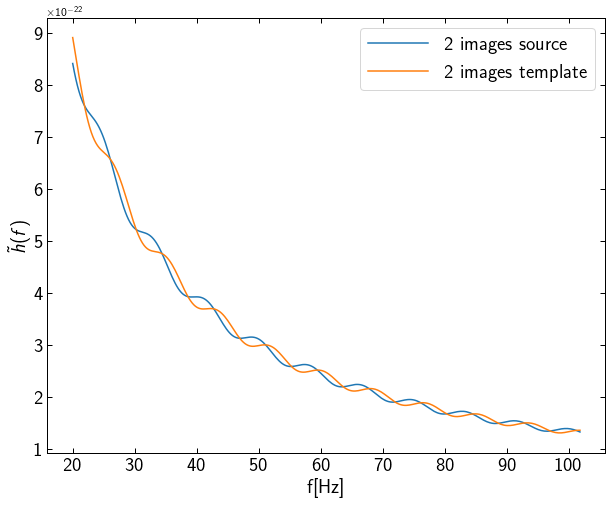

In [78]:
pp.figure(figsize = (10, 8))
#pp.rc('font', size=20)
#pp.yaxis.get_offset_text().set_fontsize(20)
hf_L_source = hf * amplification_factor_source(mu_c, mu_d, td_c, td_d)
hf_L_template = hf * amplification_factor_template(mu_c, mu_d, td_c, td_d)
pp.plot(f, np.abs(hf_L_source), label = '2 images source')
pp.plot(f, np.abs(hf_L_template), label = '2 images template')
pp.xlabel('f[Hz]', fontsize = 20)
pp.ylabel(r'$\tilde{h}(f)$', fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
pp.legend(fontsize = 20)
#pp.savefig('twoimgs_source.png', dpi = 300, bbox_inches = 'tight')

In [15]:
m, i = match(hf_L_source, hf_L_template, psd=psd_analytical, low_frequency_cutoff=20)
m, 1 - m

(0.7255425360501528, 0.27445746394984716)

### Trying four images out of four  in SIE

In [16]:
def amplification_factor_source_fourimgs(mu_a, mu_b, mu_c, mu_d, td_a, td_b, td_c, td_d):
    amp_factor_source = np.sqrt(np.abs(mu_a)) * np.exp(2 * np.pi * 1j * f * td_a) + np.sqrt(np.abs(mu_b)) * np.exp(2 * np.pi * 1j * f * td_b) \
                        - 1j * np.sqrt(np.abs(mu_c)) * np.exp(2 * np.pi * 1j * f * td_c) - 1j * np.sqrt(np.abs(mu_d)) * np.exp(2 * np.pi * 1j * f * td_d)
    return amp_factor_source

In [17]:
mu_a = 6.848177  
mu_b = 9.048417 
mu_c = -8.200782
mu_d = -4.896159
td_a = 0.         
td_b = 0.07967972 
td_c = 0.14030047 
td_d = 0.27048972

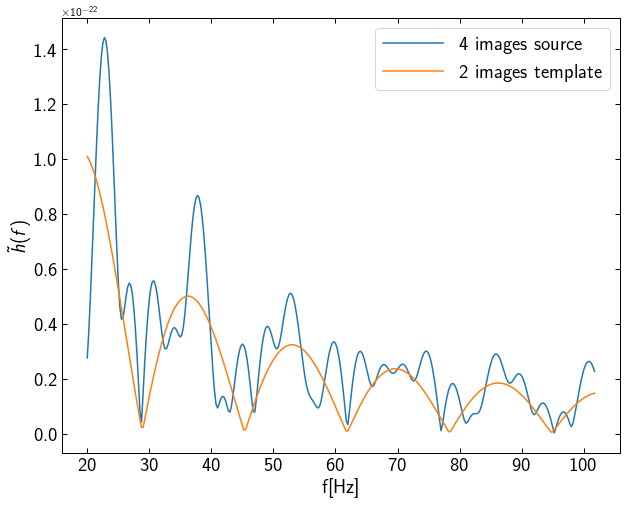

In [18]:
pp.figure(figsize = (10, 8))
hf_L_source_4imgs = hf * amplification_factor_source_fourimgs(mu_a, mu_b, mu_c, mu_d, td_a, td_b, td_c, td_d)
hf_L_template = hf * amplification_factor_template(mu_b, mu_c, td_b, td_c)
pp.plot(f, np.abs(hf_L_source_4imgs), label = '4 images source')
pp.plot(f, np.abs(hf_L_template), label = '2 images template')
pp.xlabel('f[Hz]', fontsize = 20)
pp.ylabel(r'$\tilde{h}(f)$', fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
pp.legend(fontsize = 20)
#pp.savefig('fourimgs_source.png', dpi = 300, bbox_inches = 'tight')

In [19]:
m, i = match(hf_L_source_4imgs, hf_L_template, psd=psd_analytical, low_frequency_cutoff=20)
m, 1 - m

(0.7619161324632675, 0.2380838675367325)

### Calculating mismatches in two images regime (between inner and outer caustics) in SIE

Calcuting the mismatches between the two images source waveform and unlensed waveform in the two images regimes between the inner and outer caustics.

In [20]:
datPath = "/Users/saifali/Desktop/gwlensing/SIE_glafic/data/"
fileName = "flux_twoimages_theta_0_sigma=4_sorted.csv"

In [21]:
df_data_twoimgs = pd.read_csv(datPath + fileName)
radius_range = np.array(df_data_twoimgs['source_x']) 
theta_E_sis_sigma_4 = 1.976582e-04
#df_data_twoimgs

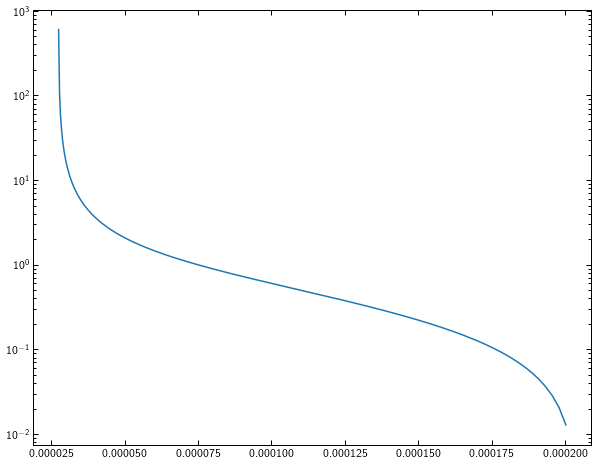

In [22]:
pp.figure(figsize = (10, 8))
pp.semilogy(df_data_twoimgs['source_x'], df_data_twoimgs['I'])

In [23]:
def amplification_factor_twoimgs(mu_arr, td_arr):
    mu_1 = mu_arr[0]
    mu_2 = mu_arr[1]
    td_1 = td_arr[0]
    td_2 = td_arr[1]
    
    F_source_twoimgs = np.sqrt(np.abs(mu_1)) * np.exp(2 * np.pi * 1j * f * td_1) - 1j * np.sqrt(np.abs(mu_2)) *  np.exp(2 * np.pi * 1j * f * td_2)
    return F_source_twoimgs

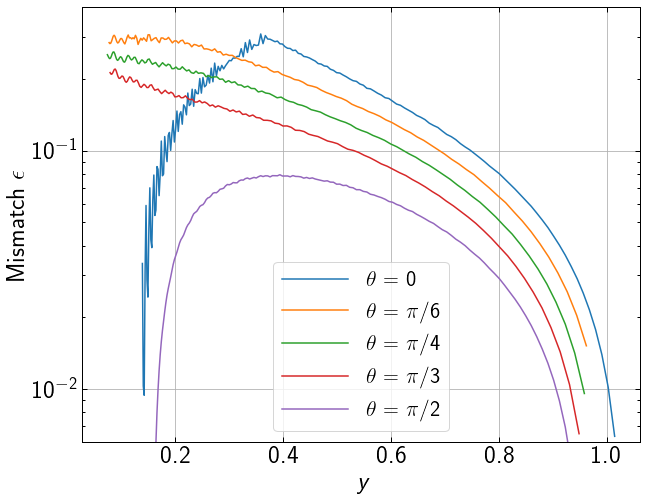

In [73]:
fileNames = ["flux_twoimages_theta_0_sigma=4_sorted.csv",
            "flux_twoimages_theta_30_sigma=4_sorted.csv",
            "flux_twoimages_theta_45_sigma=4_sorted.csv",
            "flux_twoimages_theta_60_sigma=4_sorted.csv",
            "flux_twoimages_theta_90_sigma=4_sorted.csv"]

theta = ['0', '$\pi/6$', '$\pi/4$', '$\pi/3$', '$\pi/2$']
pp.figure(figsize = (10, 8))
for i in range(len(fileNames)):
    data = pd.read_csv(datPath + fileNames[i])
    if data.columns[0] == 'source_x':
        y = data['source_x'] / theta_E_sis_sigma_4
    else:
        y = data['source_y'] / theta_E_sis_sigma_4
    
    match_twoimgs_arr = []
    for j in range(data.shape[0]):
        mu_arr = data.loc[j][1:3]
        td_arr = data.loc[j][3:5]
        hf_lensed_source_twoimgs = hf * amplification_factor_twoimgs(mu_arr, td_arr)
        m = match(hf_lensed_source_twoimgs, hf, psd=psd_analytical, low_frequency_cutoff=20)
        match_twoimgs_arr += [m[0]]
    pp.semilogy(y, 1 - np.array(match_twoimgs_arr), label = rf'$\theta$ = {theta[i]}')
pp.xlabel(r'$y$', fontsize = 25)
pp.ylabel(r'Mismatch $\epsilon$' , fontsize = 25)
pp.tick_params(axis='both', which='major', labelsize=25)
pp.legend(loc = 'best', fontsize = 22)
pp.ylim(0.006, 0.4)
pp.grid()
pp.savefig('mismatch_vs_y_twoimgs.pdf', dpi = 500, bbox_inches = 'tight')

###########################################################################

In [26]:
datPath = "/Users/saifali/Desktop/gwlensing/SIE_glafic/data/"
fileName = "flux_fourimages_theta_30_sigma=6_mismatch_sorted_preproc.csv"

In [27]:
df_data = pd.read_csv(datPath + fileName)
radius_range = np.array(df_data['source_x']) 
ein_rad_6 = 3.977795e-04
df_data.shape

(200, 9)

In [28]:
def amplification_factor_s(mu_arr, td_arr):
    F_source = np.sqrt(np.abs(mu_arr[0])) * np.exp(2 * np.pi * 1j * f * td_arr[0]) + np.sqrt(np.abs(mu_arr[1])) * np.exp(2 * np.pi * 1j * f * td_arr[1]) \
               - 1j * np.sqrt(np.abs(mu_arr[2])) * np.exp(2 * np.pi * 1j * f * td_arr[2]) - 1j * np.sqrt(np.abs(mu_arr[3])) * np.exp(2 * np.pi * 1j * f * td_arr[3])
    return F_source

def amplification_factor_t(mu_arr, td_arr):
    
    mu_1 = mu_arr[0]
    mu_2 = mu_arr[1]
    mu_3 = mu_arr[2]
    mu_4 = mu_arr[3]
    td_1 = td_arr[0]
    td_2 = td_arr[1]
    td_3 = td_arr[2]
    td_4 = td_arr[3]
    if len(set(mu_arr)) == 1:
            F_temp = np.array([0])

    # for one image case
    elif len(set(mu_arr)) == 2:
        F_temp = np.array([1])

    # for [1, 4] image pair case
    elif mu_arr[0] != 0 and mu_arr[-1] != 0 and mu_arr[1] == mu_arr[2] == 0:
        F_temp = np.sqrt(np.abs(mu_1)) * np.exp(2 * np.pi * 1j * f * td_1) - 1j * np.sqrt(np.abs(mu_4)) * np.exp(2 * np.pi * 1j * f * td_4)

    # for [3, 4] image pair case
    elif mu_arr[-2] != 0 and mu_arr[-1] != 0 and mu_arr[0] == mu_arr[1] == 0:
        F_temp = np.sqrt(np.abs(mu_3)) * np.exp(2 * np.pi * 1j * f * td_3) - 1j * np.sqrt(np.abs(mu_4)) * np.exp(2 * np.pi * 1j * f * td_4)

    # for [1, 2] image pair case
    elif mu_arr[0] != 0 and mu_arr[1] != 0 and mu_arr[2] == mu_arr[3] == 0:
        F_temp = np.sqrt(np.abs(mu_1)) * np.exp(2 * np.pi * 1j * f * td_1) - 1j * np.sqrt(np.abs(mu_2)) * np.exp(2 * np.pi * 1j * f * td_2)
        #print('[1,2]')
    
    else:
        mu_arr = np.array(mu_arr)
        td_arr = np.array(td_arr)
        mu_arr_abs = np.abs(mu_arr)
        mu_arr_min = np.max(mu_arr_abs[:2])
        mu_arr_saddle = np.max(mu_arr_abs[2:])
        index_1 = np.where(mu_arr_min == mu_arr_abs)
        index_2 = np.where(mu_arr_saddle == mu_arr_abs)
        mu_a = mu_arr[index_1]
        mu_b = mu_arr[index_2]
        td_a = td_arr[index_1]
        td_b = td_arr[index_2]
        F_temp = np.sqrt(np.abs(mu_a)) * np.exp(2 * np.pi * 1j * f * td_a) - 1j * np.sqrt(np.abs(mu_b)) * np.exp(2 * np.pi * 1j * f * td_b)   
    
    # for [1, 2, 3, 4] case
#     else:
#         mu_arr = np.array(mu_arr)
#         td_arr = np.array(td_arr)
#         mu_arr_abs = np.abs(mu_arr)
#         largest_mus = heapq.nlargest(2, mu_arr_abs)
#         index_1 = np.where(largest_mus[0] == mu_arr_abs)
#         index_2 = np.where(largest_mus[1] == mu_arr_abs)
#         mu_a = mu_arr[index_1]
#         mu_b = mu_arr[index_2]
#         td_a = td_arr[index_1]
#         td_b = td_arr[index_2]
#         F_temp = np.sqrt(np.abs(mu_a)) * np.exp(2 * np.pi * 1j * f * td_a) - 1j * np.sqrt(np.abs(mu_b)) * np.exp(2 * np.pi * 1j * f * td_b)
        #print('[1, 2, 3, 4]')
    
        
    return F_temp

In [29]:
match_arr = []
match_arr_ul = []

for i in range(df_data.shape[0]):
    mu_arr = np.array(df_data.loc[i][1:5])
    td_arr = np.array(df_data.loc[i][5:])
    hf_lensed_source = hf * amplification_factor_s(mu_arr, td_arr)
    hf_lensed_template = hf * amplification_factor_t(mu_arr, td_arr)
    m = match(hf_lensed_source, hf_lensed_template, psd=psd_analytical, low_frequency_cutoff=20)
    m_ul = match(hf_lensed_source, hf, psd=psd_analytical, low_frequency_cutoff=20)
    match_arr += [m[0]]
    match_arr_ul += [m_ul[0]]

Text(0.5, 1.0, '$\\theta = \\pi/6$')

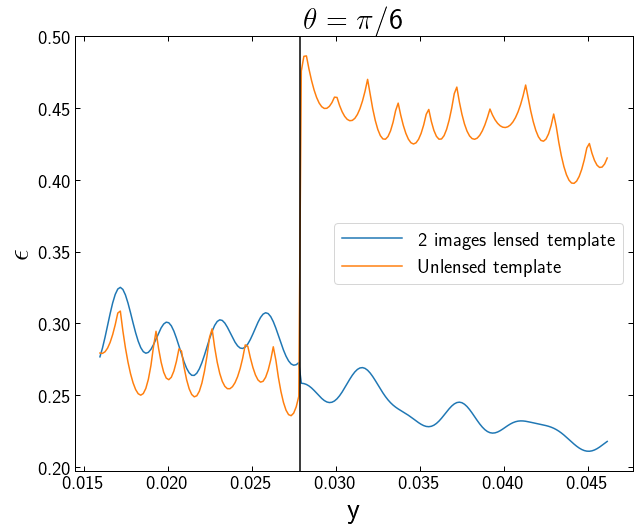

In [30]:
pp.figure(figsize = (10, 8))
pp.plot(radius_range / ein_rad_6, 1 - np.array(match_arr), label = '2 images lensed template')
pp.plot(radius_range / ein_rad_6, 1 - np.array(match_arr_ul), label = 'Unlensed template')
pp.xlabel('y', fontsize = 30)
pp.ylabel(r'$\epsilon$', fontsize = 30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
pp.legend(fontsize = 20)
pp.axvline(1.109e-05 / ein_rad_6, color = 'black')
pp.title(r'$\theta = \pi/6$')
#pp.savefig('mismatch_sie_y.png', dpi = 300, bbox_inches = 'tight')

In [31]:
datPath = "/Users/saifali/Desktop/gwlensing/SIE_glafic/data/"
fileName = "flux_fourimages_y_0.04_sigma=6_sorted_preproc.csv"

In [32]:
df_data = pd.read_csv(datPath + fileName)
theta_range = np.array(df_data['theta']) 
ein_rad_6 = 3.977795e-04
df_data.shape

(100, 9)

In [33]:
match_arr = []
match_arr_ul = []

for i in range(df_data.shape[0]):
    mu_arr = np.array(df_data.loc[i][1:5])
    td_arr = np.array(df_data.loc[i][5:])
    hf_lensed_source = hf * amplification_factor_s(mu_arr, td_arr)
    hf_lensed_template = hf * amplification_factor_t(mu_arr, td_arr)
    m = match(hf_lensed_source, hf_lensed_template, psd=psd_analytical, low_frequency_cutoff=20)
    m_ul = match(hf_lensed_source, hf, psd=psd_analytical, low_frequency_cutoff=20)
    match_arr += [m[0]]
    match_arr_ul += [m_ul[0]]

Text(0.5, 1.0, '$y = 0.04$')

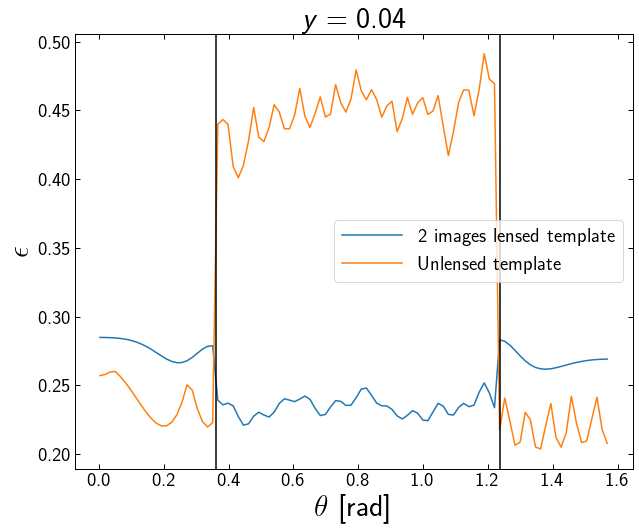

In [34]:
pp.figure(figsize = (10, 8))
pp.plot(theta_range, 1 - np.array(match_arr), label = '2 images lensed template')
pp.plot(theta_range, 1 - np.array(match_arr_ul), label = 'Unlensed template')
pp.xlabel(r'$\theta$ [rad]', fontsize = 30)
pp.ylabel(r'$\epsilon$', fontsize = 30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
pp.legend(fontsize = 20)
pp.axvline(3.621e-01, color = 'black')
pp.axvline(1.236, color = 'black')
pp.title(r'$y = 0.04$')
#pp.savefig('mismatch_sie_theta.png', dpi = 300, bbox_inches = 'tight')